# Import Libraries

In [1]:
import warnings # Чтобы не выводились предупреждения

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import requests
import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import os
%matplotlib inline
from datetime import datetime, timedelta


print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')
warnings.filterwarnings("ignore")

Tensorflow version 2.9.2
GPU is ON


# Analyse Data

In [2]:
df = pd.read_csv('data.csv', sep = ";")
df = df.set_index('REPORTDATE')

In [3]:
df.head()

,VALUE
REPORTDATE,
30.12.2013,3457625638
31.12.2013,3417092149
01.01.2014,3417092149
02.01.2014,3417092149
03.01.2014,3417092149


In [4]:
df.tail()

,VALUE
REPORTDATE,
06.10.2019,64630140507
07.10.2019,66115288637
08.10.2019,68424049766
09.10.2019,72492897583
10.10.2019,72307860851


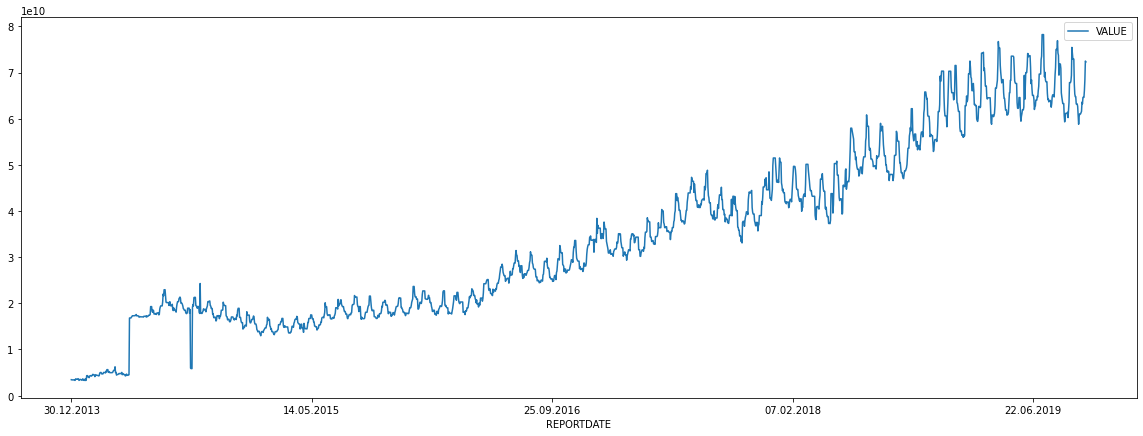

In [5]:
df.plot()


fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

# Create DataSet

In [6]:
train = df.iloc[:round(0.7*len(df))]
val = df.iloc[-round(0.3*len(df)):-round(0.5*round(0.3*len(df)))]
test = df.iloc[-round(0.5*round(0.3*len(df))):]

In [7]:
len(test) + len(train) + len(val)

2111

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 30
n_features = 1

generator_train = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
generator_validation = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [11]:
X,y = generator_train[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00362553 0.0027849  0.0027849  0.0027849  0.0027849  0.0027849
 0.0027849  0.00078886 0.00078886 0.00720632 0.00696876 0.00575834
 0.00575834 0.00575834 0.00827079 0.00665633 0.00037139 0.00238676
 0.00478788 0.00478788 0.00478788 0.00150266 0.00251613 0.00409406
 0.00760595 0.00098905 0.00098905 0.00098905 0.00048018 0.0074083 ]
Predict this y: 
 [[0.]]


# Create a LSTM-Model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, BatchNormalization, Dropout, Bidirectional
from keras.metrics import RootMeanSquaredError
from keras.optimizers import SGD
from keras import initializers
import math

opt = SGD(learning_rate=0.01, momentum=0.9)
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=(n_input, n_features)))

model.add((LSTM(50, activation='relu')))

model.add(Dense(10,kernel_initializer=initializer, bias_initializer=initializer,  activation='sigmoid')) # кол-во нейронов в слое
model.add(Dense(n_features))
model.compile(optimizer=opt, loss='mse', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10,921
Trainable params: 10,921
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(generator_train,epochs=50, validation_data = generator_validation)

Epoch 1/50
1448/1448 [==============================] - 84s 55ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 2/50
1448/1448 [==============================] - 73s 50ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 3/50
1448/1448 [==============================] - 68s 47ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 4/50
1448/1448 [==============================] - 73s 50ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 5/50
1448/1448 [==============================] - 69s 48ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 6/50
1448/1448 [==============================] - 71s 49ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 -

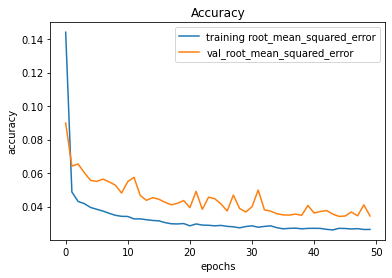

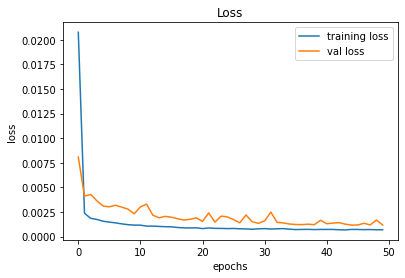

In [14]:
plt.figure(0)
plt.plot(model.history.history['root_mean_squared_error'], label='training root_mean_squared_error')
plt.plot(model.history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Test Model

## Normalised data

In [20]:
test_predictions = []
for i in range(n_input-1):
    test_predictions.append(scaled_test[i]) 

In [21]:
first_eval_batch = scaled_test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
  for i in range(len(test)-3):
      current_pred = model.predict(current_batch)[0]
      test_predictions.append(current_pred) 
      current_batch = np.append(current_batch[:,1:,:],[[scaled_test[n_input+i]]],axis=1)
except:
  pass

1/1 [==============================] - 0s 20ms/step


In [22]:
test_copy = test.copy()
test_copy['VALUE'] = scaled_test
test_copy['Predictions'] = np.array(test_predictions)
test_copy

,VALUE,Predictions
REPORTDATE,,
29.11.2018,1.069489,1.069489
30.11.2018,1.082487,1.082487
01.12.2018,1.082487,1.082487
02.12.2018,1.082487,1.082487
03.12.2018,1.082487,1.082487
...,...,...
06.10.2019,1.272292,1.248431
07.10.2019,1.303092,1.270938
08.10.2019,1.350974,1.311026


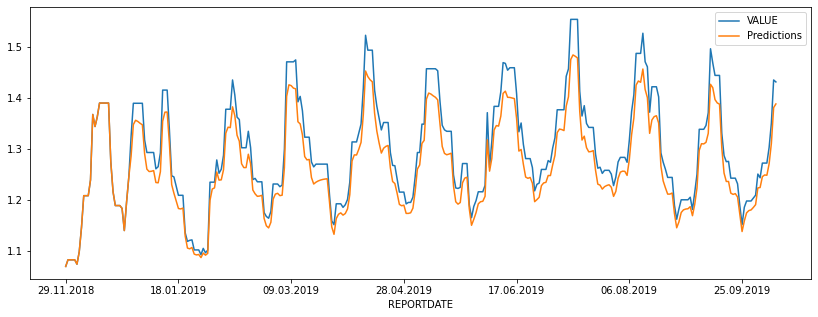

In [23]:
test_copy.plot(figsize=(14,5))

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mean_squared_error(test_copy['VALUE'],test_copy['Predictions'])

0.0012795686785066305

## Real data

In [25]:
test_copy2 = test.copy()

true_predictions = scaler.inverse_transform(test_predictions)
test_copy2['Predictions'] = true_predictions
test_copy2

,VALUE,Predictions
REPORTDATE,,
29.11.2018,54851402138,5.485140e+10
30.11.2018,55478147995,5.547815e+10
01.12.2018,55478147995,5.547815e+10
02.12.2018,55478147995,5.547815e+10
03.12.2018,55478147995,5.547815e+10
...,...,...
06.10.2019,64630140507,6.347960e+10
07.10.2019,66115288637,6.456485e+10
08.10.2019,68424049766,6.649781e+10


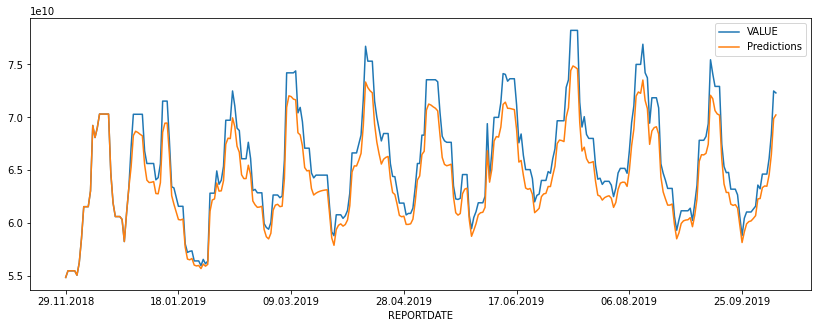

In [26]:
test_copy2.plot(figsize=(14,5))

In [27]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_copy2['VALUE'],test_copy2['Predictions'])

0.0006409149823843048

## Predict New Month

In [29]:
new_predictions = []
first_eval_batch = scaled_test[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
  for i in range(31):
      current_pred = model.predict(current_batch)[0]
      new_predictions.append(current_pred) 
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
except:
  pass

1/1 [==============================] - 0s 21ms/step


In [30]:
test_copy_3 = test.copy()
test_copy_3

,VALUE
REPORTDATE,
29.11.2018,54851402138
30.11.2018,55478147995
01.12.2018,55478147995
02.12.2018,55478147995
03.12.2018,55478147995
...,...
06.10.2019,64630140507
07.10.2019,66115288637
08.10.2019,68424049766


In [31]:
new_data_list = ['11.10.2019','12.10.2019','13.10.2019','14.10.2019','15.10.2019','16.10.2019','17.10.2019','18.10.2019','19.10.2019','20.10.2019','21.10.2019','22.10.2019','23.10.2019','24.10.2019','25.10.2019','26.10.2019','27.10.2019','28.10.2019','29.10.2019','30.10.2019','31.10.2019','01.11.2019','02.11.2019','03.11.2019','04.11.2019','05.11.2019','06.11.2019','07.11.2019','08.11.2019','09.11.2019','10.11.2019']

In [32]:
new_prediction_list = scaler.inverse_transform(new_predictions)
predicted_df=pd.DataFrame({'REPORTDATE':new_data_list})
predicted_df['VALUE'] = new_prediction_list
predicted_df = predicted_df.set_index('REPORTDATE')

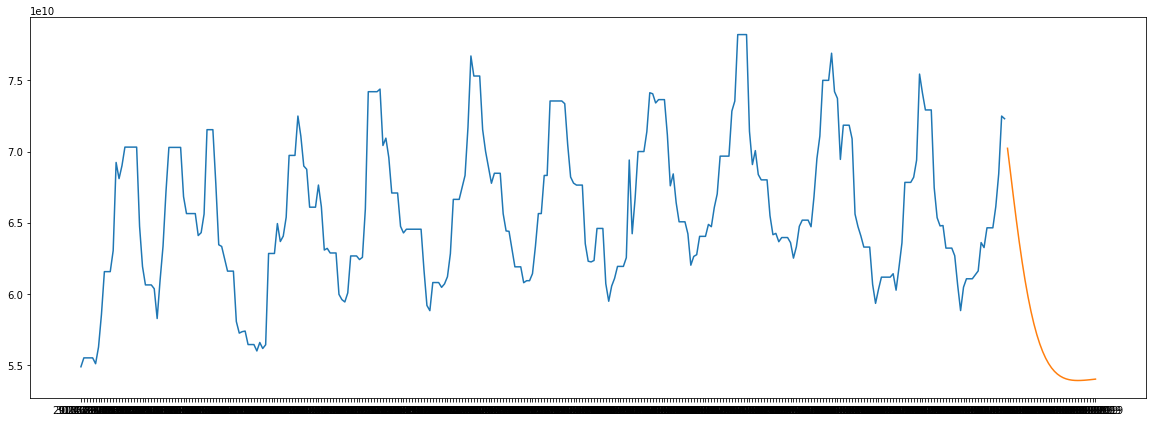

In [38]:
plt.figure(figsize = (20, 7))
plt.plot(test_copy_3)
plt.plot(predicted_df)
plt.show()

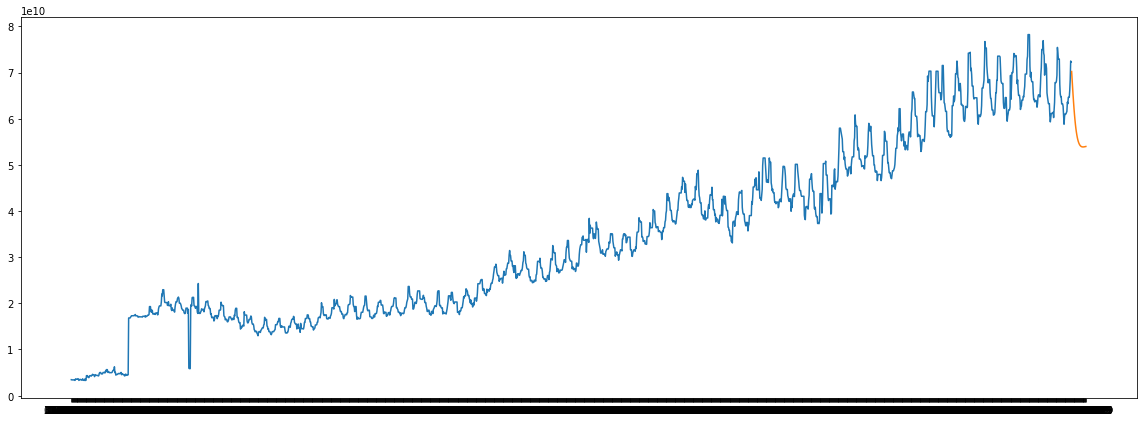

In [37]:
plt.figure(figsize = (20, 7))
plt.plot(df)
plt.plot(predicted_df)
plt.show()

In [35]:
predicted_df.to_csv('predicted.csv')

In [36]:
model.save('model.h5')